<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W08_AutoEncoders_GANs/W8_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 8 Part 1
# AutoEncoders (AEs) and Variational AutoEncoders (VAEs)

__Instructor:__ Konrad Kording

__Content creators:__ Richard Lange, Arash Ash

__Content reviewers:__ Ann-Katrin Reuel

## Today's agenda
In the first tutorial of Week 8, we are going to

1. Think about unsupervised learning and get a bird's eye view of why it is useful
2. See the connection between AutoEncoding and dimensionality reduction
3. Start thinking about neural networks as generative models
4. Put on our Bayesian hats and turn AEs into VAEs

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = '' #@param {type:"string"}
my_pod = 'Select' #@param ['Select', 'upain', 'ah-damn-optimizer', 'backpropagandists', 'backpropers','excel-erators','GAN-gsters','han-not-solo','hufflefluffs','lets-taco-bout-it','natural-networkers','pytorture','sigmoids','strong-signals','the-denominators','the-travellers', 'the-weekenders', 'tomorrows-incredibles', 'brute-force']
my_email = '' #@param {type:"string"}
tutorial = 'W8D1'

# start timing
import time
try:t0;
except NameError: t0 = time.time()

In [2]:
# @title Slides
from IPython.display import HTML
HTML('<iframe src="https://docs.google.com/presentation/d/e/2PACX-1vQTsDQET4TdoyJv_Ql_wm6ct9cxFMVghMXnqGYutHJW_3io7D1wM_F0cOj1-31KwQ-gV5eHWSni77mO/embed?start=false&loop=false&delayms=3000" frameborder="0" width="480" height="299" allowfullscreen="true" mozallowfullscreen="true" webkitallowfullscreen="true"></iframe>')


## Recap the experience from last week

Video available at https://youtube.com/watch?v=VHhtye5SwY0


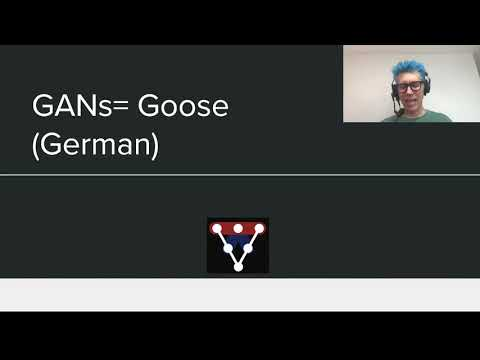

In [3]:
#@title Video: Week 7 Recap
import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo
video = YouTubeVideo(id="VHhtye5SwY0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Setup

In [4]:
# we need to first upgrade the Colab's TorchVision
!pip install --upgrade torchvision

     |████████████████████████████████| 23.2 MB 23.2 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.5 MB/s eta 0:00:32tcmalloc: large alloc 1147494400 bytes == 0x55eee9dfc000 @  0x7fce8ea95615 0x55eeafd2c3bc 0x55eeafe0d18a 0x55eeafd2f1cd 0x55eeafe21b3d 0x55eeafda3458 0x55eeafd9e02f 0x55eeafd30aba 0x55eeafda32c0 0x55eeafd9e02f 0x55eeafd30aba 0x55eeafd9fcd4 0x55eeafe22986 0x55eeafd9f350 0x55eeafe22986 0x55eeafd9f350 0x55eeafe22986 0x55eeafd9f350 0x55eeafd30f19 0x55eeafd74a79 0x55eeafd2fb32 0x55eeafda31dd 0x55eeafd9e02f 0x55eeafd30aba 0x55eeafd9fcd4 0x55eeafd9e02f 0x55eeafd30aba 0x55eeafd9eeae 0x55eeafd309da 0x55eeafd9f108 0x55eeafd9e02f
     |████████████████████████████████| 881.9 MB 1.9 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvis

In [5]:
# imports
import matplotlib.pylab as plt
from tqdm.notebook import tqdm, trange
from math import sqrt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torch.utils.data import DataLoader

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# @title Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [7]:
#@title Helper functions

def image_moments(image_batches, n_batches=None):
    """
    Compute mean an covariance of all pixels from batches of images
    """
    m1, m2 = torch.zeros((), device=DEVICE), torch.zeros((), device=DEVICE)
    n = 0
    for im in tqdm(image_batches, total=n_batches, leave=False,
                   desc='Computing pixel mean and covariance...'):
        im = im.to(DEVICE)
        b = im.size()[0]
        im = im.view(b, -1)
        m1 = m1 + im.sum(dim=0)
        m2 = m2 + (im.view(b,-1,1) * im.view(b,1,-1)).sum(dim=0)
        n += b
    m1, m2 = m1/n, m2/n
    cov = m2 - m1.view(-1,1)*m1.view(1,-1)
    return m1.cpu(), cov.cpu()

def pca_encoder_decoder(mu, cov, k):
    """
    Compute encoder and decoder matrices for PCA dimensionality reduction
    """
    mu = mu.view(1,-1)
    u, s, v = torch.svd_lowrank(cov, q=k)
    W_encode = v / torch.sqrt(s)
    W_decode = u * torch.sqrt(s)
    
    def pca_encode(x):
        # Encoder: subtract mean image and project onto top K eigenvectors of
        # the data covariance
        return (x.view(-1,mu.numel()) - mu) @ W_encode
    
    def pca_decode(h):
        # Decoder: un-project then add back in the mean
        return (h @ W_decode.T) + mu
    
    return pca_encode, pca_decode

# Helper for plotting images
def plot_torch_image(image, ax=None):
    ax = ax if ax is not None else plt.gca()
    c, h, w = image.size()
    cm = 'gray' if c==1 else None
    # Torch images have shape (channels, height, width) but matplotlib expects
    # (height, width, channels) or just (height,width) when grayscale
    ax.imshow(image.detach().cpu().permute(1,2,0).squeeze(), cmap=cm)
    ax.set_xticks([])
    ax.set_yticks([])

---
# Section 1: Supervised and unsupervised learning

Video available at https://youtube.com/watch?v=Vw9MLfb4bi4


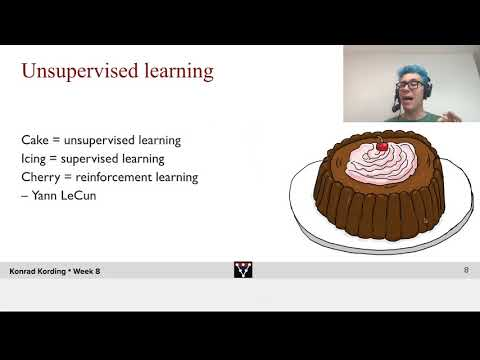

In [8]:
#@title Video: Datasets

try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="Vw9MLfb4bi4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

In [9]:
#@title Download a few standard image datasets while the above video plays
# See https://pytorch.org/docs/stable/torchvision/datasets.html
%%capture

# MNIST contains handwritten digets 0-9, in grayscale images of size (1,28,28)
mnist = tv.datasets.MNIST('./mnist/', train=True, transform=tv.transforms.ToTensor(), download=True)
mnist_val = tv.datasets.MNIST('./mnist/', train=False, transform=tv.transforms.ToTensor(), download=True)
# CIFAR10 contains 10 object classes in color images of size (3,32,32)
cifar10 = tv.datasets.CIFAR10('./cifar10/', train=True, transform=tv.transforms.ToTensor(), download=True)
cifar10_val = tv.datasets.CIFAR10('./cifar10/', train=False, transform=tv.transforms.ToTensor(), download=True)

Unsupervised and semi-supervised learning are broad concepts that can be applied in many different domains. In machine learning research, however, computer vision is by far the most common domain for studying these things. Using image datasets will also let us build on what you learned last week. But keep in mind that the techniques you learn this week are quite general!

It's always a good idea to visualize your data. Let's look at some samples of images in each of the example datasets we've downloaded:

### Visualize MNIST examples

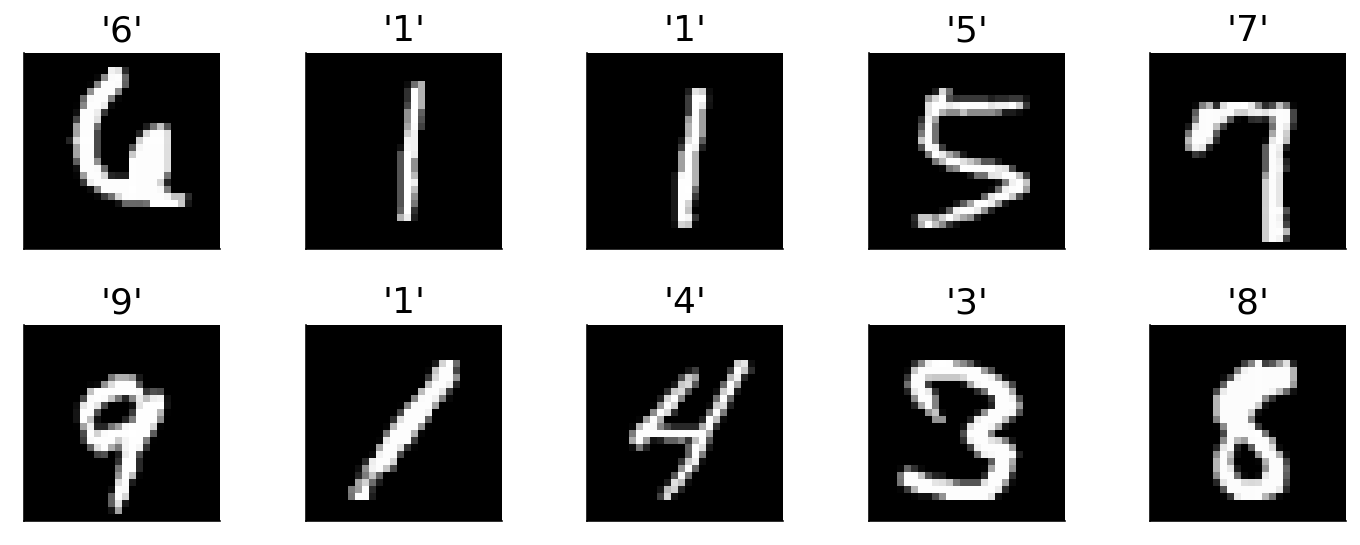

MNIST contains 60000 examples each of size torch.Size([1, 28, 28]) with values ranging in [0.0,1.0]


In [10]:
minval, maxval = float('inf'), float('-inf')
plt.figure(figsize=(10,4))
for i in range(10):
    idx = torch.randint(len(mnist), size=())
    image, label_idx = mnist[idx]
    plt.subplot(2,5,i+1)
    plot_torch_image(image)
    plt.title(f"'{label_idx}'")
    minval, maxval = min(minval, image.min()), max(maxval, image.max())
plt.show()

print(f"MNIST contains {len(mnist)} examples each of size {image.size()} with values ranging in [{minval},{maxval}]")

### Visualize CIFAR10 examples

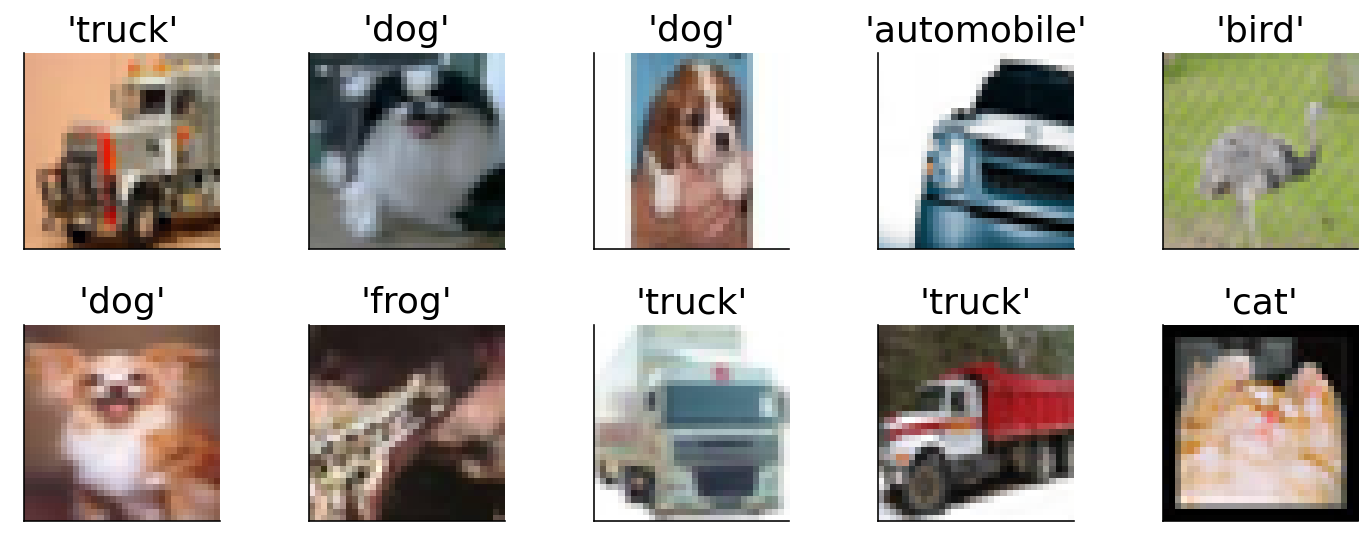

CIFAR10 contains 50000 examples each of size torch.Size([3, 32, 32]) with values ranging in [0.0,1.0]


In [11]:
minval, maxval = float('inf'), float('-inf')
plt.figure(figsize=(10,4))
for i in range(10):
    idx = torch.randint(len(cifar10), size=())
    image, label_idx = cifar10[idx]
    plt.subplot(2,5,i+1)
    plot_torch_image(image)
    plt.title(f"'{cifar10.classes[label_idx]}'")
    minval, maxval = min(minval, image.min()), max(maxval, image.max())
plt.show()

print(f"CIFAR10 contains {len(cifar10)} examples each of size {image.size()} with values ranging in [{minval},{maxval}]")

The goal of today is to make sense of these images in an _unsupervised_ way, that is without the labels.

### Select a dataset

We've built today's tutorial to be flexible. It should work more-or-less out of the box with both MNIST and CIFAR (and other image datasets). MNIST is in many ways simpler, and the results will likely look better and run a bit faster if using MNIST. But we are leaving it up to you to pick which one you want to experiment with!


In [12]:
# Uncomment this to select MNIST
my_dataset = mnist
my_dataset_name = "MNIST"
my_dataset_size = (1, 28, 28)
my_dataset_dim = 28*28
my_valset = mnist_val

# Uncomment this to select CIFAR
# my_dataset = cifar10
# my_dataset_name = "CIFAR"
# my_dataset_size = (3, 32, 32)
# my_dataset_dim = 3*32*32
# my_valset = cifar10_val

---
# Section 2: AutoEncoders
## Conceptual introduction to AutoEncoders



Video available at https://youtube.com/watch?v=QwsHAKDN_vw


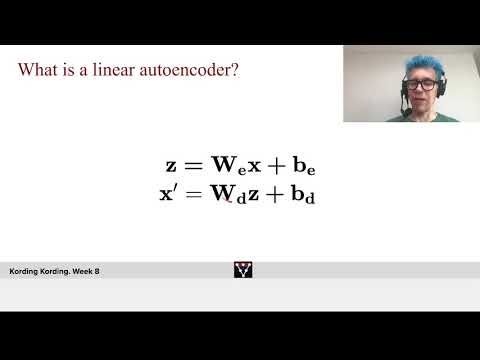

In [13]:
#@title Video: Linear Autoencoders

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="QwsHAKDN_vw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Build a linear AutoEncoder

Now we'll create our first autoencoder. It will reduce images down to $K$ dimensions. The architecture will be quite simple: the input will be linearly mapped to a single hidden layer with $K$ units, which will then be linearly mapped back to an output that is the same size as the input:
$$\mathbf{x} \longrightarrow \mathbf{h} \longrightarrow \mathbf{x'}$$

The loss function we'll use will simply be mean squared error (MSE) quantifying how well the reconstruction ($\mathbf{x'}$) matches the original image ($\mathbf{x}$):
$$\text{MSE Loss} = \sum_{i=1}^{N} ||\mathbf{x}_i - \mathbf{x'}_i||^2_2$$

If all goes well, then the AutoEncoder will learn, **end to end**, a good "encoding" or "compression" of inputs ($\mathbf{x \longrightarrow h}$) as well as a good "decoding" ($\mathbf{h \longrightarrow x'}$).

The first choice to make is the dimensionality of $\mathbf{h}$. We'll see more on this below, but For MNIST, 5 to 20 is plenty. For CIFAR, we need more like 50 to 100 dimensions.

Try a variety of values for $K$ in each dataset to get a feeling of it's impact.

In [14]:
# Pick your own K
K = ...

### Exercise 1
### Fill in the missing parts of the `LinearAutoEncoder` class and training loop

1. The `LinearAutoEncoder` as two stages: an `encoder` which linearly maps from inputs to a hidden layer of size `K` (with no nonlinearity), and a `decoder` which maps back from `K` up to the number of pixels in each image (`my_dataset_dim`).
2. The training loop will minimize MSE loss, as written above.

In [16]:
class LinearAutoEncoder(nn.Module):
    def __init__(self, K):
        ####################################################################
        # Fill in all missing code below (...),
        # then remove or comment the line below to test your class
        raise NotImplementedError("Please complete the LinearAutoEncoder class!")
        #################################################################### 
        super(LinearAutoEncoder, self).__init__()
        self.enc_lin = ... # your code here
        self.dec_lin = ... # your code here
    
    def encode(self, x):
        h = ... # your code here
        return h
    
    def decode(self, h):
        x_prime = ... # your code here
        return x_prime

    def forward(self, x):
        flat_x = x.view(x.size()[0], -1)
        h = self.encode(flat_x)
        return self.decode(h).view(x.size())

def train_autoencoder(autoencoder, dataset, epochs=20, batch_size=250):
    autoencoder.to(DEVICE)
    optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=2)
    mse_loss = torch.zeros(epochs*len(dataset)//batch_size, device=DEVICE)
    i = 0
    for epoch in trange(epochs, desc='Epoch'):
        for im_batch, _ in loader:
            im_batch = im_batch.to(DEVICE)
            optim.zero_grad()
            ####################################################################
            # Fill in all missing code below (...),
            # then remove or comment the line below to test your function
            raise NotImplementedError("Please complete the train_autoencoder function!")
            #################################################################### 
            loss = ... # your code here
            loss.backward()
            optim.step()

            mse_loss[i] = loss.detach()
            i += 1
    # After training completes, make sure the model is on CPU so we can easily
    # do more visualizations and demos.
    autoencoder.to('cpu')
    return mse_loss.cpu()

# Uncomment to test your code
# lin_ae = LinearAutoEncoder(K)
# lin_losses = train_autoencoder(lin_ae, my_dataset)

# plt.figure()
# plt.plot(lin_losses)
# plt.ylim([0, 2*torch.as_tensor(lin_losses).median()])
# plt.xlabel('Training batch')
# plt.ylabel('MSE Loss')
# plt.show()

One way to think about AutoEncoders is that they automatically discover good dimensionality-reduction of the data. Another easy and common technique for dimensionality reduction is to project data onto the top $K$ **principal components** (Principal Component Analysis or PCA). For comparison, let's also do PCA.

In [18]:
# PCA requires finding the top K eigenvectors of the data covariance. Start by
# finding the mean and covariance of the pixels in our dataset
loader = DataLoader(my_dataset, batch_size=32, pin_memory=True)
mu, cov = image_moments((im for im, _ in loader), n_batches=len(my_dataset)//32)
pca_encode, pca_decode = pca_encoder_decoder(mu, cov, K)

Computing pixel mean and covariance...:   0%|          | 0/1875 [00:00<?, ?it/s]

Let's visualize some of the reconstructions ($\mathbf{x'}$) side-by-side with the input images ($\mathbf{x}$).

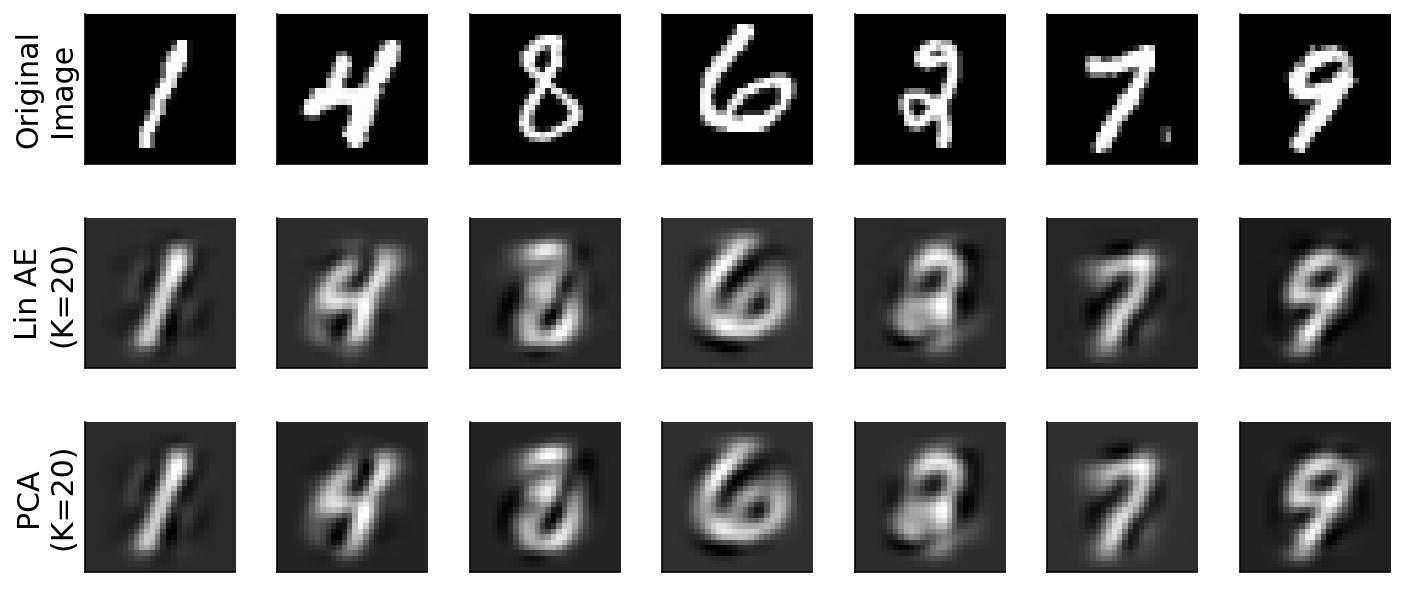

In [19]:
n_plot = 7
plt.figure(figsize=(10,4.5))
for i in range(n_plot):
    idx = torch.randint(len(my_dataset), size=())
    image, _ = my_dataset[idx]
    # Get reconstructed image from autoencoder
    with torch.no_grad():
        reconstruction = lin_ae(image.unsqueeze(0)).reshape(image.size())
    
    # Get reconstruction from PCA dimensionality reduction
    h_pca = pca_encode(image)
    recon_pca = pca_decode(h_pca).reshape(image.size())
    
    plt.subplot(3,n_plot,i+1)
    plot_torch_image(image)
    if i == 0:
        plt.ylabel('Original\nImage')
    
    plt.subplot(3,n_plot,i+1+n_plot)
    plot_torch_image(reconstruction)
    if i == 0:
        plt.ylabel(f'Lin AE\n(K={K})')
    
    plt.subplot(3,n_plot,i+1+2*n_plot)
    plot_torch_image(recon_pca)
    if i == 0:
        plt.ylabel(f'PCA\n(K={K})')
plt.show()

## Quiz Question 1

Compare the PCA-based reconstructions to those from the linear autoencoder. Is one better than the other? Are they equally good? Equally bad?

In [20]:
linear_ae_vs_pca = "" #@param{type:'string'}

If you're interested, Appendix C includes a plot of explained-variance as a function of $K$, as well as some discussion of why fraction of explained variance using PCA is a rough and not very good guide to choosing $K$ for a given dataset.

## Building a nonlinear convolutional autoencoder


Video available at https://youtube.com/watch?v=mzHY6rW_4Eo


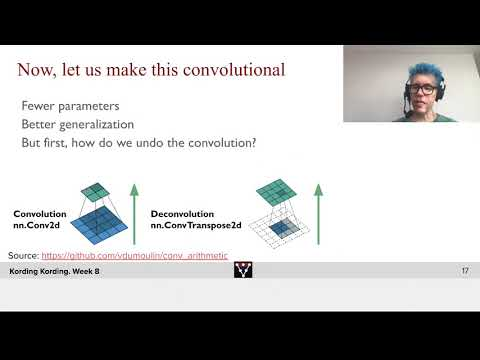

In [21]:
#@title Video: Convolutional Autoencoders

video = YouTubeVideo(id="mzHY6rW_4Eo", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

The `nn.Linear` layer by default has a "bias" term, which is a learnable offset parameter separate for each output unit. Just like the PCA encoder "centered" the data by subtracting off the average image (`mu`) before encoding and added it back in during decoding, a bias term in the decoder can effectively account for the first moment of the data (AKA the average of all images in the training set). Convolution layers do have bias parameters, but the bias is applied per filter rather than per pixel location. If we're generating RGB images, then `Conv2d` will learn only 3 biases: one for each of R, G, and B.

For some conceptual continuity with both PCA and the `nn.Linear` layers above, the next block defines a custom layer for adding a learnable per-pixel offset. This custom layer will be used twice: as the first stage of the encoder and as the final stage of the decoder. Ideally, this means that the rest of the neural net can focus on fitting more interesting fine-grained structure.

In [22]:
class BiasLayer(nn.Module):
    def __init__(self, shape):
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape)
        self.bias = nn.Parameter(init_bias, requires_grad=True)
    
    def forward(self, x):
        return x + self.bias

With that out of the way, we will next define a **nonlinear** and **convolutional** autoencoder. Here's a quick tour of the architecture:

1. The **encoder** once again maps from images to $\mathbf{h}\in\mathbb{R}^K$. This will use a `BiasLayer` followed by two convolutional layers (`nn.Conv2D`), followed by flattening and linearly projecting down to $K$ dimensions. The convolutional layers will have `ReLU` nonlinearities on their outputs. 
1. The **decoder** inverts this process, taking in vectors of length $K$ and outputting images. Roughly speaking, its architecture is a "mirror image" of the encoder: the first decoder layer is linear, followed by two **deconvolution** layers (`nn.ConvTranspose2d`). The `ConvTranspose2d` layers will have `ReLU` nonlinearities on their _inputs_. This "mirror image" between the encoder and decoder is a useful and near-ubiquitous convention. The idea is that the decoder can then learn to approximately invert the encoder, but it is not a strict requirement (and it does not guarantee the decoder will be an exact inverse of the encoder!).

Below is a schematic of the architecture for MNIST. Notice that the width and height dimensions of the image planes reduce after each `nn.Conv2d` and increase after each `nn.ConvTranspose2d`. With CIFAR10, the architecture is the same but the exact sizes will differ a bit.

<img src="https://raw.githubusercontent.com/CIS-522/course-content/main/W08_VAE_GANs/students/conv_sizes.png" />

We will not go into detail about `ConvTranspose2d` here. For now, just know that it acts a bit like, but not exactly, an inverse to `Conv2d`. The following code demonstrates this change in sizes:

In [23]:
dummy_image = torch.zeros(my_dataset_size).unsqueeze(0)
channels = my_dataset_size[0]
dummy_conv = nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=5)
dummy_conv_transpose = nn.ConvTranspose2d(in_channels=channels, out_channels=channels, kernel_size=5)

print(f'Size of image is {dummy_image.size()}')
print(f'Size of Conv2D(image) {dummy_conv(dummy_image).size()}')
print(f'Size of ConvTranspose2D(image) {dummy_conv_transpose(dummy_image).size()}')
print(f'Size of ConvTranspose2D(Conv2D(image)) {dummy_conv_transpose(dummy_conv(dummy_image)).size()}')

Size of image is torch.Size([1, 1, 28, 28])
Size of Conv2D(image) torch.Size([1, 1, 24, 24])
Size of ConvTranspose2D(image) torch.Size([1, 1, 32, 32])
Size of ConvTranspose2D(Conv2D(image)) torch.Size([1, 1, 28, 28])


### Exercise 2
### Fill in code for the `ConvAutoEncoder` module


In [24]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvAutoEncoder, self).__init__()
        
        # With padding=0, the number of pixels cut off from each image dimension
        # is filter_size // 2. Double it to get the amount of pixels lost in
        # width and height per Conv2D layer, or added back in per 
        # ConvTranspose2D layer.
        filter_reduction = 2 * (filter_size // 2)

        # After passing input through two Conv2d layers, the shape will be
        # 'shape_after_conv'. This is also the shape that will go into the first
        # deconvolution layer in the decoder
        self.shape_after_conv = (num_filters,
                                 my_dataset_size[1]-2*filter_reduction,
                                 my_dataset_size[2]-2*filter_reduction)
        flat_size_after_conv = self.shape_after_conv[0] \
            * self.shape_after_conv[1] \
            * self.shape_after_conv[2]
        ####################################################################
        # Fill in all missing code below (...),
        # then remove or comment the line below to test your class
        raise NotImplementedError("Please complete the ConvAutoEncoder class!")
        #################################################################### 
        # Your code here
        ... # Create encoder layers (BiasLayer, Conv2d, Conv2d, Flatten, Linear)
        ... # Create decoder layers (Linear, Unflatten(-1, self.shape_after_conv), ConvTranspose2d, ConvTranspose2d, BiasLayer)

    def encode(self, x):
        ... # Your code here: encode batch of images (don't forget ReLUs!)
        return h
    
    def decode(self, h):
        ... # Your code here: decode batch of h vectors (don't forget ReLUs!)
        return x_prime

    def forward(self, x):
        return self.decode(self.encode(x))

# Uncomment to test your solution
# conv_ae = ConvAutoEncoder(K=K)
# assert conv_ae.encoder(my_dataset[0][0].unsqueeze(0)).numel() == K, \
#     "Encoder output size should be K!"
# conv_losses = train_autoencoder(conv_ae, my_dataset)
# plt.figure()
# plt.plot(lin_losses)
# plt.plot(conv_losses)
# plt.legend(['Lin AE', 'Conv AE'])
# plt.xlabel('Training batch')
# plt.ylabel('MSE Loss')
# plt.ylim([0,2*max(torch.as_tensor(conv_losses).median(), torch.as_tensor(lin_losses).median())])
# plt.show()

You should see that the `ConvAutoEncoder` achieved lower MSE loss than the linear one. If not, you may need to retrain it (or run another few training epochs from where it left off). We make fewer guarantees on this working with CIFAR10, but it should definitely work with MNIST.

Now let's visually compare the reconstructed images from the linear and nonlinear autoencoders. Keep in mind that both have the same dimensionality for $\mathbf{h}$!

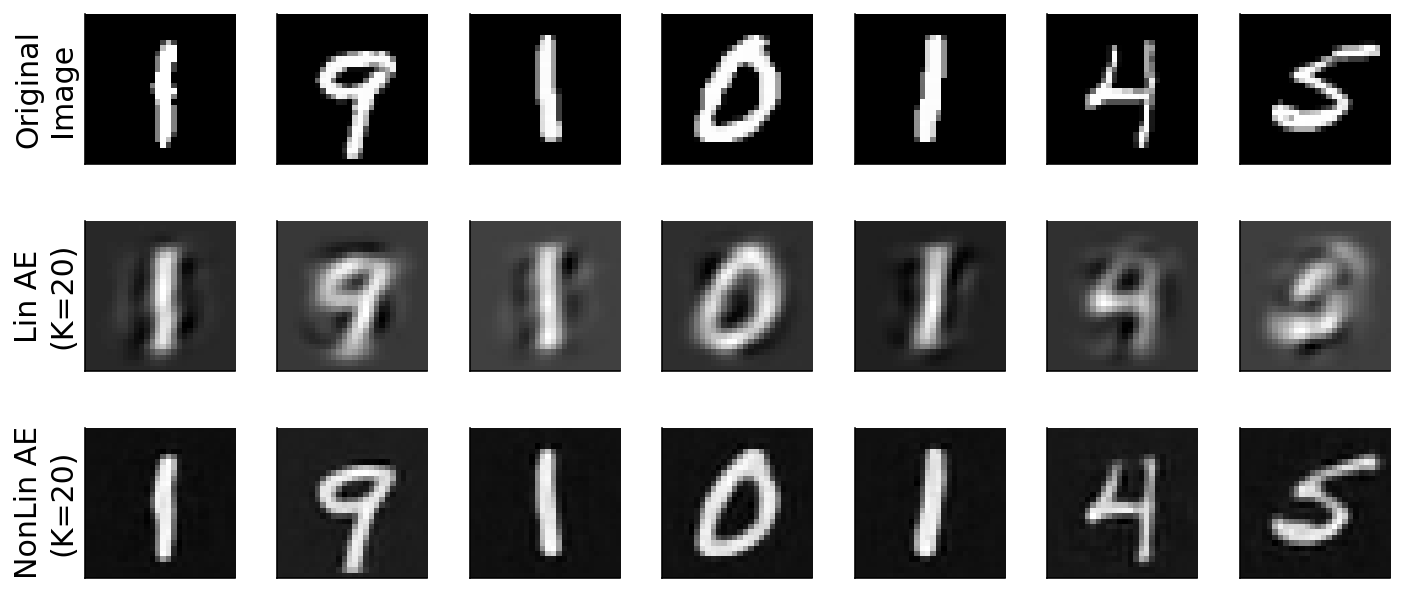

In [26]:
n_plot = 7
plt.figure(figsize=(10,4.5))
for i in range(n_plot):
    idx = torch.randint(len(my_dataset), size=())
    image, _ = my_dataset[idx]
    with torch.no_grad():
        # Get reconstructed image from linear autoencoder
        lin_recon = lin_ae(image.unsqueeze(0))[0]
    
        # Get reconstruction from deep (nonlinear) autoencoder
        nonlin_recon = conv_ae(image.unsqueeze(0))[0]
    
    plt.subplot(3,n_plot,i+1)
    plot_torch_image(image)
    if i == 0:
        plt.ylabel('Original\nImage')
    
    plt.subplot(3,n_plot,i+1+n_plot)
    plot_torch_image(lin_recon)
    if i == 0:
        plt.ylabel(f'Lin AE\n(K={K})')
    
    plt.subplot(3,n_plot,i+1+2*n_plot)
    plot_torch_image(nonlin_recon)
    if i == 0:
        plt.ylabel(f'NonLin AE\n(K={K})')
plt.show()

## Inspecting the hidden representations



Video available at https://youtube.com/watch?v=HcvTrvCntBY


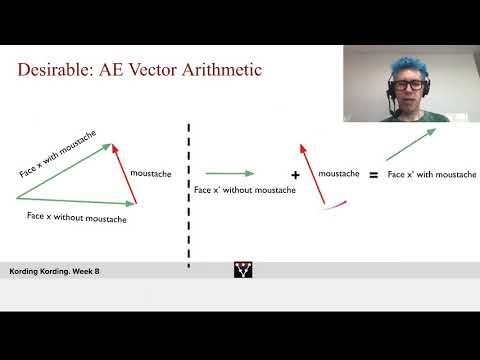

In [27]:
#@title Video: Latent Space

video = YouTubeVideo(id="HcvTrvCntBY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Let's start by plotting points in the hidden space ($\mathbf{h}$), colored by class of the image (which, of course, the autoencoder didn't know about during training!)

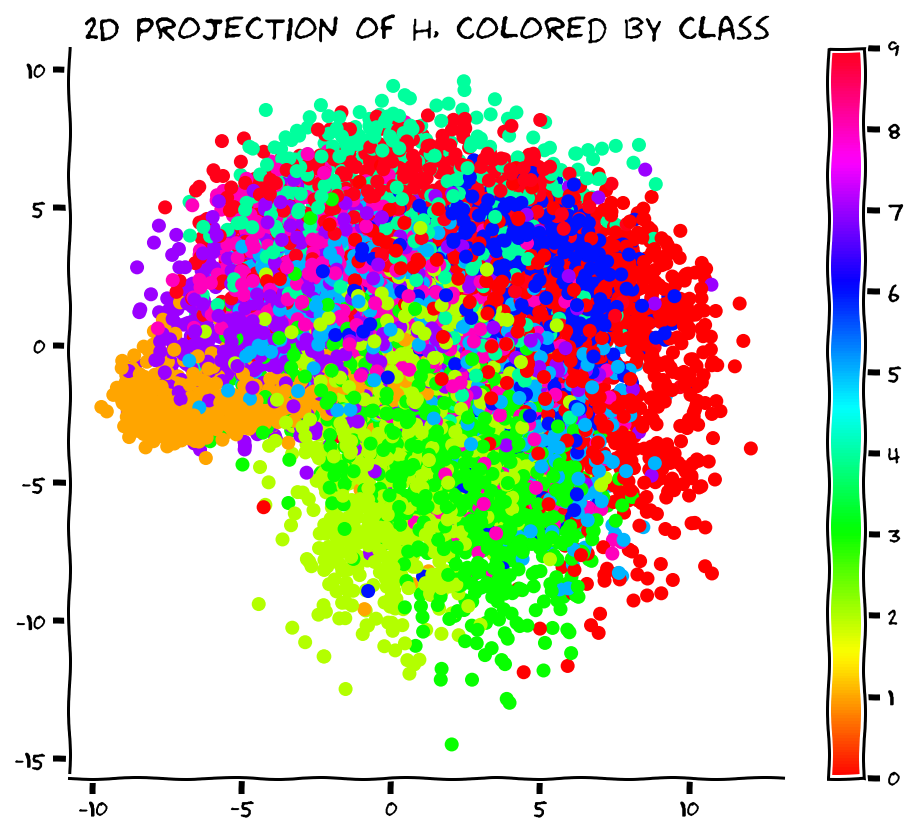

In [28]:
h_vectors = torch.zeros(len(my_valset), K, device=DEVICE)
labels = torch.zeros(len(my_valset), dtype=torch.int32)
loader = DataLoader(my_valset, batch_size=200, pin_memory=True)
conv_ae.to(DEVICE)
i = 0
for im, la in loader:
    b = im.size()[0]
    h_vectors[i:i+b, :] = conv_ae.encode(im.to(DEVICE))
    labels[i:i+b] = la
    i += b
conv_ae.to('cpu')
h_vectors = h_vectors.detach().cpu()
_, _, h_pcs = torch.pca_lowrank(h_vectors, q=2)
h_xy = h_vectors @ h_pcs

with plt.xkcd():
    plt.figure(figsize=(7,6))
    plt.scatter(h_xy[:,0], h_xy[:,1], c=labels, cmap='hsv')
    plt.title('2D projection of h, colored by class')
    plt.colorbar()
    plt.show()

To explore the hidden representations, $\mathbf{h}$, we're going to pick two random images from the dataset and interpolate them 3 different ways. Let's introduce some notation for this: we'll use a variable $t \in [0,1]$ to gradually transition from image $\mathbf{x}_1$ at $t=0$ to image $\mathbf{x}_2$ at $t=1$. Using $\mathbf{x}(t)$ to denote the interpolated output, the three methods will be

1. interpolate the raw pixels, so $$\mathbf{x}(t) = (1-t) \cdot \mathbf{x}_1 + t \cdot \mathbf{x}_2$$
2. interpolate their encodings from the **linear** AE, so $$\mathbf{x}(t) = \text{linear_decoder}((1-t) \cdot \text{linear_encoder}(\mathbf{x}_1) + t \cdot  \text{linear_encoder}(\mathbf{x}_2))$$
3. interpolate their encodings from the **nonlinear** AE, so $$\mathbf{x}(t) = \text{conv_decoder}((1-t) \cdot \text{conv_encoder}(\mathbf{x}_1) + t \cdot  \text{conv_encoder}(\mathbf{x}_2))$$

Note: This demo will likely look better using MNIST than using CIFAR, but you can answer the question below for either one of them. 

##Quiz Question 2

What do you notice about the "interpolated" images, especially around $t \approx 1/2$? How many distinct classes do you see in the bottom row?
Re-run the above cell a few times to look at multiple examples.

In [29]:
interp_observations = "" #@param{type:'string'}

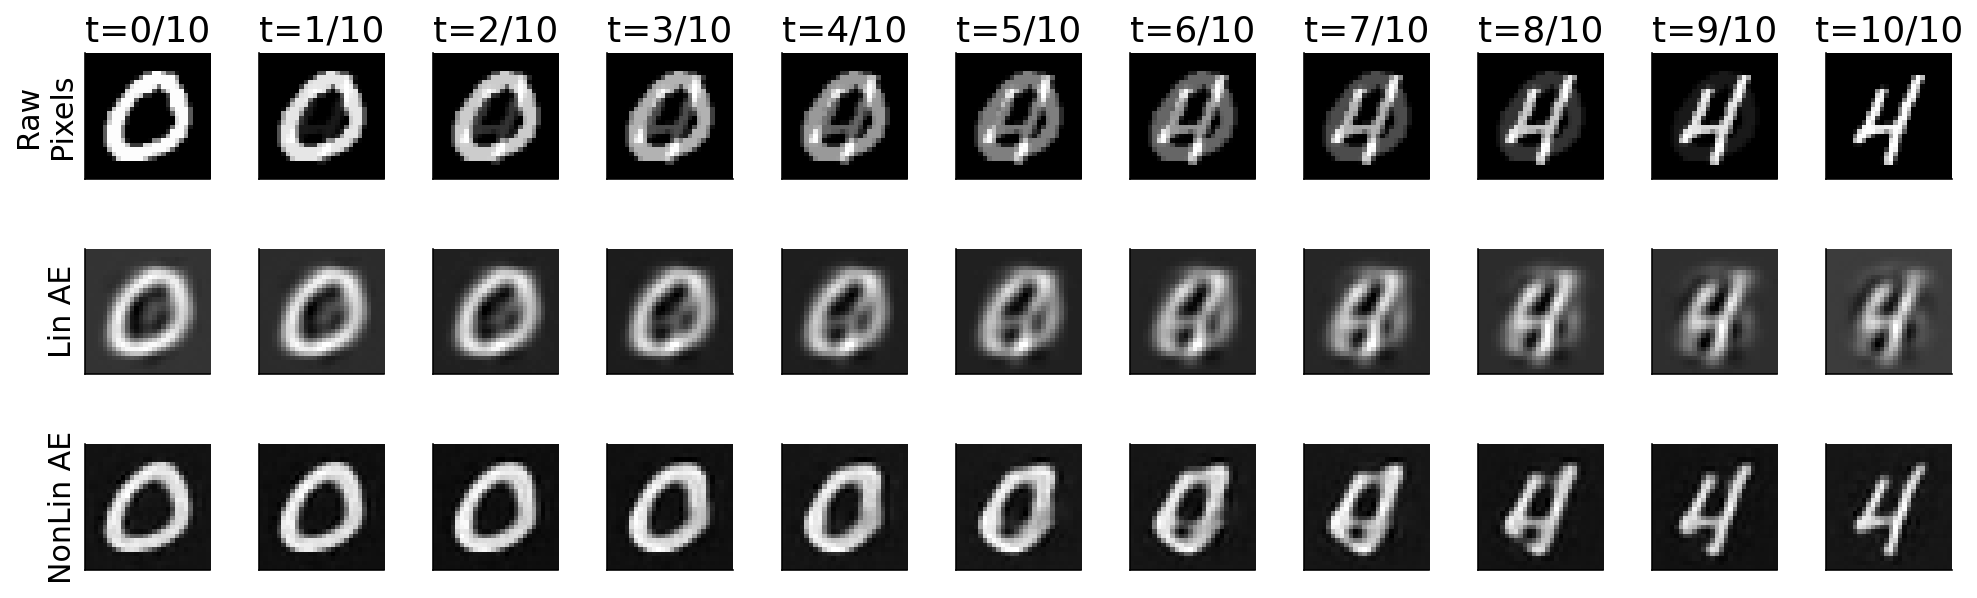

In [30]:
idx1 = torch.randint(len(my_dataset), size=())
idx2 = torch.randint(len(my_dataset), size=())
x1, _ = my_dataset[idx1]
x2, _ = my_dataset[idx2]
n_interp = 11

with torch.no_grad():
    h1_lin = lin_ae.encode(x1.reshape(1,-1))
    h2_lin = lin_ae.encode(x2.reshape(1,-1))
    h1_conv = conv_ae.encode(x1.unsqueeze(0))
    h2_conv = conv_ae.encode(x2.unsqueeze(0))

plt.figure(figsize=(14, 4.5))
for i in range(n_interp):
    t = i / (n_interp-1)
    pixel_interp = (1-t)*x1 + t*x2
    plt.subplot(3,n_interp,i+1)
    plot_torch_image(pixel_interp)
    if i == 0:
        plt.ylabel('Raw\nPixels')
    plt.title(f't={i}/{n_interp-1}')
    
    with torch.no_grad():
        lin_ae_interp = lin_ae.decode((1-t)*h1_lin + t*h2_lin)
    plt.subplot(3,n_interp,i+1+n_interp)
    plot_torch_image(lin_ae_interp.reshape(my_dataset_size))
    if i == 0:
        plt.ylabel('Lin AE')
    
    with torch.no_grad():
        conv_ae_interp = conv_ae.decode((1-t)*h1_conv + t*h2_conv)[0]
    plt.subplot(3,n_interp,i+1+2*n_interp)
    plot_torch_image(conv_ae_interp)
    if i == 0:
        plt.ylabel('NonLin AE')
plt.show()

---
# Section 3: Generative models and density networks



Video available at https://youtube.com/watch?v=h96JaT5Jyi4


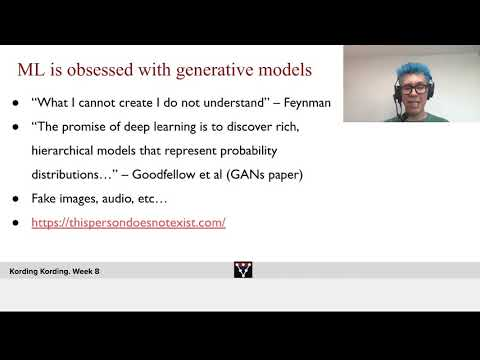

In [31]:
#@title Video: Generating with Gaussians

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="h96JaT5Jyi4", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Generating novel images from the decoder

If we isolate the decoder part of the AutoEncoder, what we have is a neural network that takes as input a vector of size $K$ and produces as output an image that looks something like our training data. Recall that in our earlier notation, we had an input $\mathbf{x}$ that was mapped to a low-dimensional hidden representation $\mathbf{h}$ which was then decoded into a reconstruction of the input, $\mathbf{x'}$:
$$\mathbf{x} \overset{\text{encode}}{\longrightarrow} \mathbf{h} \overset{\text{decode}}{\longrightarrow} \mathbf{x'}\, .$$
Partly as a matter of convention, and partly to distinguish where we are going next from the previous section, we're going to introduce a new variable, $\mathbf{z} \in \mathbb{R}^K$, which will take the place of $\mathbf{h}$. The key difference is that while $\mathbf{h}$ is produced by the encoder for a particular $\mathbf{x}$, $\mathbf{z}$ will be drawn out of thin air from a prior of our choosing:
$$\mathbf{z} \sim p(\mathbf{z})\\ \mathbf{z} \overset{\text{decode}}{\longrightarrow} \mathbf{x}\, .$$
(Note that it is also conventional to drop the "prime" on $\mathbf{x}$ when it is no longer being thought of as a "reconstruction").

## Exercise 3
###Sample $\mathbf{z}$ from a standard normal and visualize the images produced

In [32]:
def generate_images(autoencoder, K, n_images=1):
    """Generate n_images 'new' images from the decoder part of the given
    autoencoder.

    returns (n_images, channels, height, width) tensor of images
    """
    # Concatenate tuples to get (n_images, channels, height, width)
    output_shape = (n_images,) + my_dataset_size
    with torch.no_grad():
        ####################################################################
        # Fill in all missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Please complete the generate_images function!")
        #################################################################### 
        ... # Your code here: sample z, pass through autoencoder.decode(), and reshape output.

# Uncomment to run it
# images = generate_images(conv_ae, K, n_images=25)
# plt.figure(figsize=(5,5))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plot_torch_image(images[i])
# plt.show()

## Formalizing the problem: density estimation with maximum likelihood



Video available at https://youtube.com/watch?v=rx3IlM4qnvw


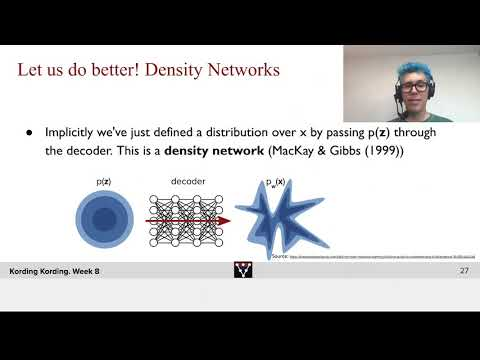

In [34]:
#@title Video: Density Networks

video = YouTubeVideo(id="rx3IlM4qnvw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Note: we've moved the technical details of "formalizing the problem" to Appendix A.1 at the end of this notebook. Those who want more of the theoretical/mathematical backstory are encouraged to read it. Those who just want to build a VAE, carry on!

---
# Section 4: Variational Auto-Encoders (VAEs)

Video available at https://youtube.com/watch?v=RgOF3XJL5vw


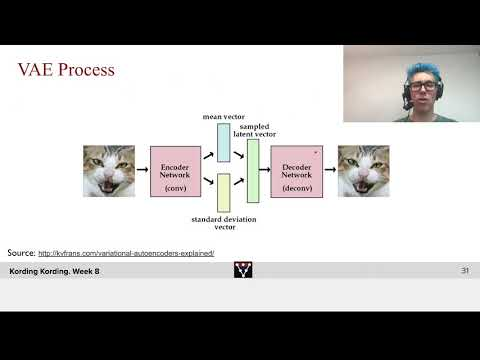

In [35]:
#@title Video: VAE Samples

try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="RgOF3XJL5vw", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Components of a VAE
## Recognition models and density networks

Variational AutoEncoders (VAEs) are a lot like the classic AutoEncoders (AEs) you just saw, but where we explicitly think about probability distributions. In the language of VAEs, the __encoder__ is replaced with a __recognition model__, and the __decoder__ is replaced with a __density network__.

Where in a classic autoencoder the encoder maps from images to a single hidden vector,
$$\mathbf{x} \overset{\text{AE}}{\longrightarrow} \mathbf{h} \, , $$ in a VAE we would say that a recognition model maps from inputs to entire __distributions__ over hidden vectors,
$$\mathbf{x} \overset{\text{VAE}}{\longrightarrow} q(\mathbf{z}) \, ,$$
which we will then sample from.
We'll say more in a moment about what kind of distribution $q(\mathbf{z})$ is.
Part of what makes VAEs work is that the loss function will require good reconstructions of the input not just for a single $\mathbf{z}$, but _on average_ from samples of $\mathbf{z} \sim q(\mathbf{z})$.

In the classic autoencoder, we had a decoder which maps from hidden vectors to reconstructions of the input:
$$\mathbf{h} \overset{\text{AE}}{\longrightarrow} \mathbf{x'} \, .$$
In a density network, reconstructions are expressed in terms of a distribution:
$$\mathbf{z} \overset{\text{VAE}}{\longrightarrow} p(\mathbf{x}|\mathbf{z};\mathbf{w}) $$
where, as above, $p(\mathbf{x}|\mathbf{z};\mathbf{w})$ is defined by mapping $\mathbf{z}$ through a density network then treating the resulting $f(\mathbf{z};\mathbf{w})$ as the mean of a (Gaussian) distribution over $\mathbf{x}$.

## Exercise 4
### Sampling from $q(\mathbf{z})$

How can a neural network (the __recognition model__) output an entire probability distribution $$\mathbf{x} \longrightarrow q(\mathbf{z}) \, ?$$
One idea would be to make the weights of the neural network stochastic, so that every time the network is run, a different $\mathbf{z}$ is produced. (In fact, this is quite common in [Bayesian Neural Networks](https://medium.com/neuralspace/bayesian-neural-network-series-post-1-need-for-bayesian-networks-e209e66b70b2), but this isn't what people use in VAEs.)

Instead, we will start by committing to a particular _family_ of distributions. We'll then have the recognition model output the _parameters_ of $q$, which we'll call $\phi$. A common choice, which we will use throughout, is the family of isotropic multivariate Gaussians$^\dagger$:
$$q(\mathbf{z};\phi) = \mathcal{N}(\mathbf{z};\boldsymbol{\mu},\sigma^2\mathbf{I}_K) = \prod_{k=1}^K \mathcal{N}(z_k; \mu_k, \sigma^2)$$
where the $K+1$ parameters are$^*$
$$\phi = \lbrace{\mu_1, \mu_2, \ldots, \mu_K, \log(\sigma)}\rbrace \, .$$
By defining the last entry of $\phi$ as the _logarithm_ of $\sigma$, the last entry can be any real number while enforcing the requirement that $\sigma > 0$.

A recognition model is a neural network that takes $\mathbf{x}$ as input and produces $\phi$ as output. The purpose of the following exercise is not to write a recognition model (that will come later), but to clarify the relationship between $\phi$ and $q(\mathbf{z})$. You will write a function, `rsample`, which takes as input a batch $\phi$s and will output a set of samples of $\mathbf{z}$ drawn from $q(\mathbf{z};\phi)$.

In [36]:
def rsample(phi, n_samples):
    """Sample z ~ q(z;phi)
    Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
    entries of each row of phi are the mean of q, and phi[:,-1] is the log
    standard deviation
    """
    b, kplus1 = phi.size()
    k = kplus1-1
    mu, sig = phi[:, :-1], phi[:,-1].exp()
    ####################################################################
    # Fill in all missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Please complete the rsample function!")
    ####################################################################
    ... # your code here!

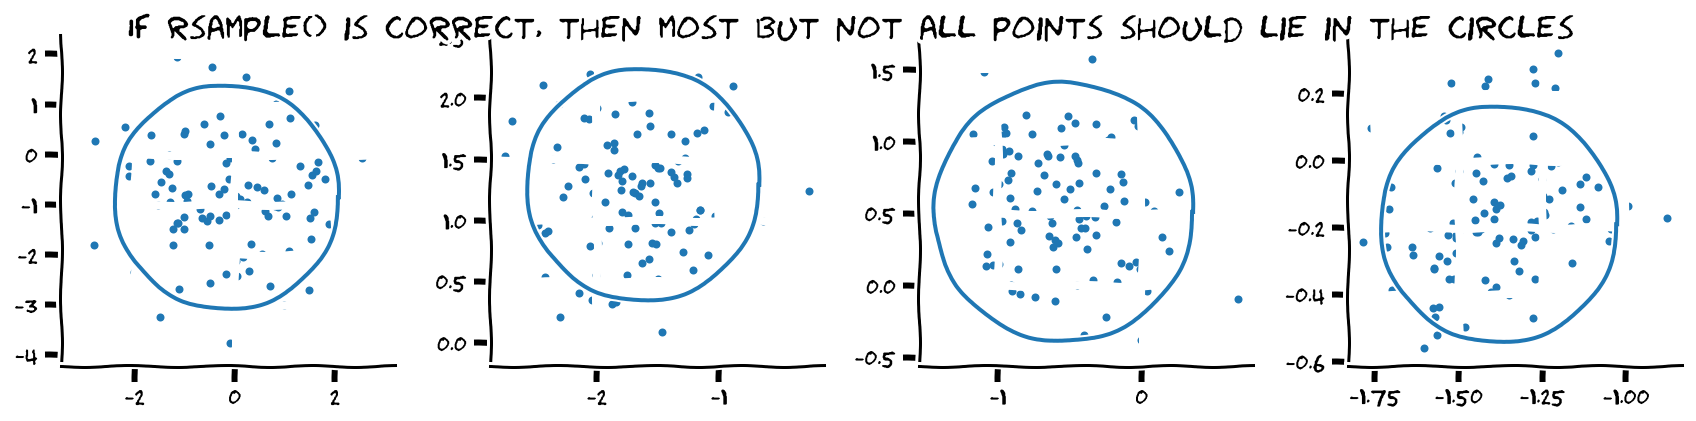

In [38]:
# Testing rsample()
phi = torch.randn(4, 3, device=DEVICE)
zs = rsample(phi, 100)
assert zs.size() == (4, 100, 2), "rsample size is incorrect!"
assert zs.device == phi.device, "rsample device doesn't match phi device!"
zs = zs.cpu()

with plt.xkcd():
    plt.figure(figsize=(12,3))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.scatter(zs[i,:,0], zs[i,:,1], marker='.')
        th = torch.linspace(0, 6.28318, 100)
        x, y = torch.cos(th), torch.sin(th)
        # Draw 2-sigma contours
        plt.plot(2*x*phi[i,2].exp().item()+phi[i,0].item(), 2*y*phi[i,2].exp().item()+phi[i,1].item())
        # plt.title(f'mu={phi[i,0].item():.2f},{phi[i,1].item():.2f}, sig={phi[i,2].exp().item():.3f}')
        plt.xlim(-5,5)
        plt.ylim(-5,5)
        plt.grid()
        plt.axis('equal')
    plt.suptitle('If rsample() is correct, then most but not all points should lie in the circles')
    plt.show()

---

$^\dagger$ PyTorch has a `MultivariateNormal` class which handles multivariate Gaussian distributions with arbitrary covariance matrices. It is not very beginner-friendly, though, so we will write our own functions to work with $\phi$, which will both teach you some implementation details and is not very hard especially if we use only an isotropic ($\sigma$) or diagonal ($\lbrace{\sigma_1, \ldots, \sigma_K}\rbrace$) covariance

$^*$ Another common parameterization is to use a separate $\sigma$ for each dimension of $\mathbf{z}$, in which case $\phi$ would instead contain $2K$ parameters:
$$\phi = \lbrace{\mu_1, \mu_2, \ldots, \mu_K, \log(\sigma_1), \ldots, \log(\sigma_K)}\rbrace \, .$$

## VAE training: maximize the Evidence Lower BOund (ELBO)


<!-- Rather than **minimizing** mean squared error as we did with the classic autoencoder, the training objective for VAEs is to **maximize** a quantity called the ELBO. The ELBO for a single data point $\mathbf{x}_i$ is defined as
$$\text{ELBO}(\mathbf{x}_i,\phi,\mathbf{w}) = \mathbb{E}_{q(\mathbf{z};\phi)}\left[ \log \frac{p(\mathbf{x}_i,\mathbf{z};\mathbf{w})}{q(\mathbf{z};\phi)}\right] \, ,$$
which in practice is split into two terms that we can actually make sense of:
$$\text{ELBO}(\mathbf{x}_i,\phi,\mathbf{w}) = \color{blue}{\mathbb{E}_{q(\mathbf{z};\phi)}\left[\log p(\mathbf{x}_i|\mathbf{z};\mathbf{w}) \right]} - \color{green}{KL(q(\mathbf{z};\phi)||p(\mathbf{z}))} \, .$$ -->

Video available at https://youtube.com/watch?v=-99NskgKDo0


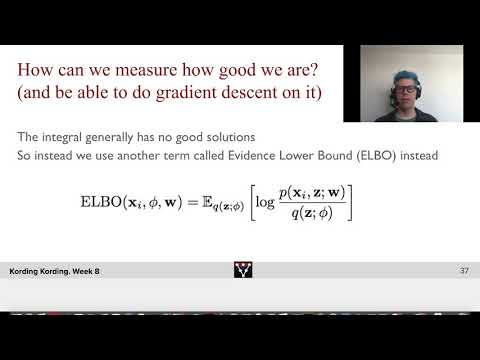

In [39]:
#@title Video: ELBO

video = YouTubeVideo(id="-99NskgKDo0", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

A full derivation and further explanation of the ELBO can be found in Appendix A.2 at the end of this notebook. In the following few sections, we provide implementations of `log_p_x` and `kl_q_p` for you, since the technical details of each can be somewhat opaque.

<!-- To actually _train_ a VAE, we decompose the ELBO into two terms,
$$\text{ELBO}(\mathbf{x}_i,\phi,\mathbf{w}) = \color{blue}{\mathbb{E}_{q(\mathbf{z};\phi)}\left[\log p(\mathbf{x}_i|\mathbf{z};\mathbf{w}) \right]} - \color{green}{KL(q(\mathbf{z};\phi)||p(\mathbf{z}))} \, ,$$
each of which we will be able to compute relatively easily:

1. a <font color="blue">**reconstruction term**</font>, which is maximized if $q(\mathbf{z};\phi)$ places higher probability on values of $\mathbf{z}$ that do a good job of reconstructing $\mathbf{x}_i$ after being passed through the density network. Since there is an expectation ($\mathbb{E}_{q(\mathbf{z};\phi)}[\ldots]$), this term wants _all_ samples from $\mathbf{z} \sim q(\mathbf{z};\phi)$ to produce good reconstructions of a given $\mathbf{x}_i$. This term should remind you of the MSE loss we used to train the original AutoEncoders.
2. a <font color="green">**regularization term**</font> which penalizes $q(\mathbf{z};\phi)$ for deviating too far from the prior, $p(\mathbf{z})$. -->

First, we'll implement the $\color{blue}{\mathbb{E}_{q(\mathbf{z};\phi)}\left[\log p(\mathbf{x}_i|\mathbf{z};\mathbf{w}) \right]}$ term in PyTorch in a function called `log_p_x`.
Earlier, we introduced the density network with $p(\mathbf{x}|\mathbf{z};\mathbf{w}) = \mathcal{N}\left(f(\mathbf{z};\mathbf{w}), \sigma^2_x\mathbf{I}_P\right)$. The $\log$ of this is
\begin{align}\log p(\mathbf{x}_i|\mathbf{z};\mathbf{w}) &= -\frac{1}{2} \frac{||\mathbf{x}_i - f(\mathbf{z};\mathbf{w})||_2^2}{\sigma_\mathbf{x}^2} - P \log(\sigma_\mathbf{x}) \\
&= -\sum_{j=1}^P \left(\frac{(x_{ij} - f(\mathbf{z};\mathbf{w})_j)^2}{2\sigma_\mathbf{x}^2} + \log \sigma_\mathbf{x}\right)\end{align}
where $j$ indexes individual pixels in the image.

In [40]:
def log_p_x(x, mu_xs, sig_x):
    """Given [batch, ...] input x and [batch, n, ...] reconstructions, compute
    pixel-wise log Gaussian probability

    Sum over pixel dimensions, but mean over batch and samples.
    """
    b, n = mu_xs.size()[:2]
    # Flatten out pixels and add a singleton dimension [1] so that x will be
    # implicitly expanded when combined with mu_xs
    x = x.reshape(b, 1, -1)
    _, _, p = x.size()
    squared_error = (x - mu_xs.view(b, n, -1))**2 / (2*sig_x**2)

    # Size of squared_error is [b,n,p]. log prob is by definition sum over [p].
    # Expected value requires mean over [n]. Handling different size batches
    # requires mean over [b].
    return -(squared_error + torch.log(sig_x)).sum(dim=2).mean(dim=(0,1))

Next, we will implement the $\color{green}{KL(q(\mathbf{z};\phi)||p(\mathbf{z}))}$ term in a function called `kl_q_p`. While we could plug in the exact formula for $KL$ between two Gaussians, a more general (but more variable) approach is to write
$$KL(q(\mathbf{z};\phi)||p(\mathbf{z})) = \mathbb{E}_{q(\mathbf{z};\phi)}\left[\log q(\mathbf{z};\phi) - \log p(\mathbf{z})\right]$$
and approximate this expectation with samples of $\mathbf{z} \sim q(\mathbf{z};\phi)$ just like we did for the reconstruction term.

In [41]:
def kl_q_p(zs, phi):
    """Given [b,n,k] samples of z drawn from q, compute estimate of KL(q||p).
    phi must be size [b,k+1]

    This uses mu_p = 0 and sigma_p = 1, which simplifies the log(p(zs)) term to
    just -1/2*(zs**2)
    """
    b, n, k = zs.size()
    mu_q, log_sig_q = phi[:,:-1], phi[:,-1]
    log_p = -0.5*(zs**2)
    log_q = -0.5*(zs - mu_q.view(b,1,k))**2 / log_sig_q.exp().view(b,1,1)**2 - log_sig_q.view(b,1,-1)
    # Size of log_q and log_p is [b,n,k]. Sum along [k] but mean along [b,n]
    return (log_q - log_p).sum(dim=2).mean(dim=(0,1))

Finally, we will implement the ELBO in a function called, well, `elbo`. Recall from the video that $$\text{ELBO}(\mathbf{x}_i,\phi,\mathbf{w}) = \color{blue}{\mathbb{E}_{q(\mathbf{z};\phi)}\left[\log p(\mathbf{x}_i|\mathbf{z};\mathbf{w}) \right]} - \color{green}{KL(q(\mathbf{z};\phi)||p(\mathbf{z}))} \, \,$$
and that we have two functions for this: `log_p_x` for the first term and `kl_q_p` for the second term. At a high level, the `elbo` function simply computes each of these terms and takes their difference!

For a bit more detail, `elbo` it will have five inputs:

* `x`, which is a _batch_ of input images of size `[batch,channels,height,width]`
* `phi`, which as before is a batch of _parameters_ of $q(\mathbf{z};\phi)$ with size `[batch,k+1]`
* `density_net`, which takes in $\mathbf{z}$s and outputs reconstructed $\mathbf{x}$s. (For those who dove into Appendix A.1 it really outputs the mean of a distribution over each $\mathbf{x}$. This is the $f(\mathbf{z};\mathbf{w})$ in the mathematical notation in the Appendix.)
* `sig_x`, which is the amount of "pixel noise" in the generative model ($\sigma_\mathbf{x}$ in the appendix). Intuitively, larger `sig_x` means that the model can be sloppier in its reconstructions, since errors are attributed to _noise_.
* `n`: the number of samples of `z` that will be sampled per input image.

In [42]:
def elbo(x, phi, density_net, sig_x, n):
    # Start by drawing n samples of z from q(z;phi)
    zs = rsample(phi, n)
    # Density net expects just [b,k] inputs, so we'll collapse together batch 
    # and samples dimensions to get [b*n,k] samples of z, then expand back out
    # separate [b,n,p] dimensions in the result
    b = x.size()[0]
    mu_xs = density_net(zs.view(b*n, -1)).view(b,n,-1)
    # Compute reconstruction and regularization terms. ELBO = diff. between them
    return log_p_x(x, mu_xs, sig_x) - kl_q_p(zs, phi)

### See the ELBO in action

What's cool about the ELBO is that it is a single objective which solves two problems at once:

1. When we maximize the ELBO with respect to $\phi$, we are making $q(\mathbf{z};\phi)$ closer to $p(\mathbf{z}|\mathbf{x};\mathbf{w})$. This approximately solves the "needle in a haystack" problem of finding which $\mathbf{z}$s are "relevant" for each $\mathbf{x}_i$. This is the probabilistic equivalent of the _encoder_ from before, which simply mapped from $\mathbf{x}$ to $\mathbf{h}$, except now we have an entire distribution $q(\mathbf{z};\phi)$.
2. When we maximize the ELBO with respect to $\mathbf{w}$, we are improving the generative model, making $p(\mathbf{x};\mathbf{w})$ closer to the distribution of training examples of $\mathbf{x}$. In other words, we are getting better at _generating new $\mathbf{x}$ from $\mathbf{z}$_.

(Further details and explanations can be found in Appendix A.2)

To see the ELBO in action, we'll use it to infer $\mathbf{z}$ for a single $\mathbf{x}$ using the decoder part of the convolutional autoencoder you built in the first part. This section may also need to be run multiple times, or with larger `steps` (especially if you chose a large $K$).

  0%|          | 0/4000 [00:00<?, ?it/s]

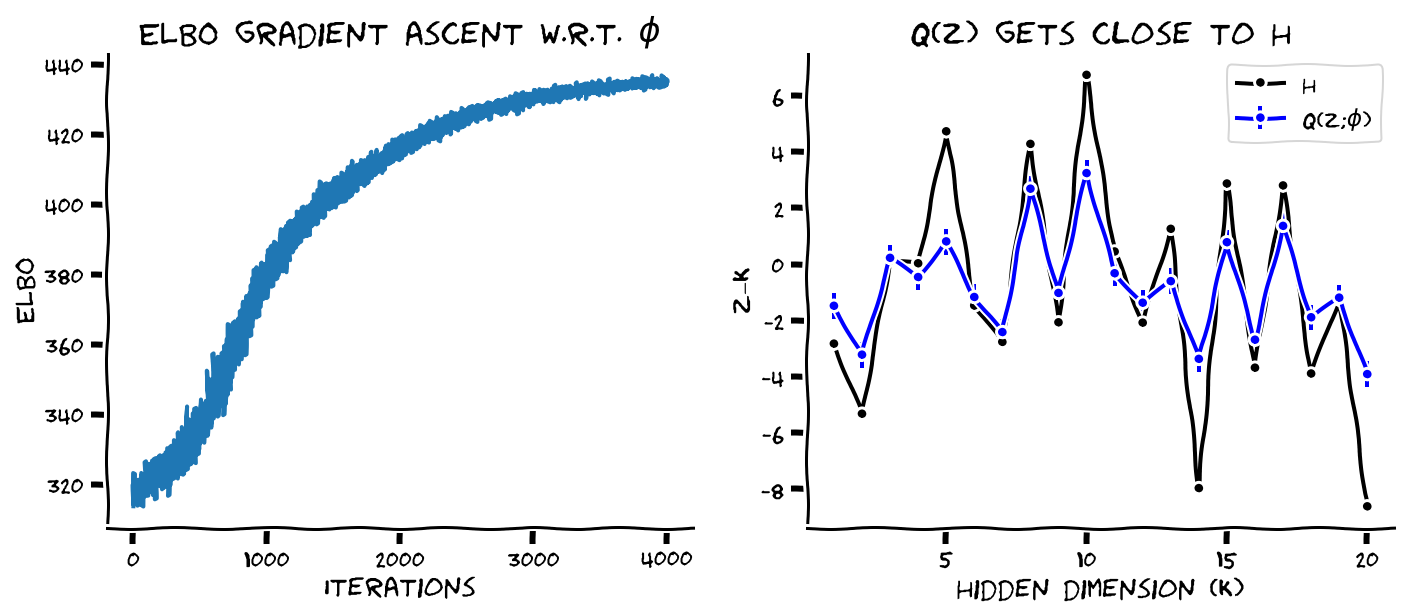

In [43]:
# Pick a random image from the validation set
idx = torch.randint(len(my_valset), size=())
x_i, _ = my_valset[idx]

# Solve for q(z;phi) by maximizing the ELBO by gradient ascent
steps = 4000
phi = torch.zeros(1, K+1, requires_grad=True, device=DEVICE)
# sig_x controls amount of 'pixel noise'.
# Lower --> more 'strict' reconstructions, so q(z) will be narrower.
# Higher --> more 'lax' reconstructions, so q(z) will be wider.
sig_x = torch.tensor(0.5, device=DEVICE)
optim = torch.optim.Adam([phi], lr=0.001)
elbo_vals = torch.zeros(steps, device=DEVICE)
x_i = x_i.to(DEVICE).unsqueeze(0)
conv_ae.to(DEVICE)
for iter in trange(steps, leave=False):
    optim.zero_grad()
    loss = -elbo(x_i, phi, density_net=conv_ae.decode, sig_x=sig_x, n=16)
    loss.backward()
    optim.step()
    elbo_vals[iter] = -loss.detach()
x_i = x_i.to('cpu')
conv_ae.to('cpu')
phi = phi.detach().cpu().flatten()

mu_q = phi[:-1]
sig_q = torch.exp(phi[-1])*torch.ones(K)

# For comparison, what would our AE encoder have produced?
h = conv_ae.encode(x_i).detach().flatten()

# Plot
with plt.xkcd():
    plt.figure(figsize=(10,4.5))
    plt.subplot(1,2,1)
    plt.plot(elbo_vals.cpu())
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.title('ELBO gradient ascent w.r.t. $\phi$')
    plt.subplot(1,2,2)
    plt.plot(torch.arange(1,K+1), h, marker='.', color='k', linestyle='-')
    plt.errorbar(torch.arange(1,K+1), mu_q, sig_q, marker='.', linestyle='-', color='b')
    plt.legend(['h', 'q(z;$\phi$)'])
    plt.xlabel('hidden dimension (k)')
    plt.ylabel('z_k')
    plt.title('q(z) gets close to h')
    plt.show()

Hopefully you see that we successfully maximized the ELBO by ascending its gradient with respect to $\phi$, and that the resulting distribution $q(\mathbf{z};\phi)$ is close to the vector $\mathbf{h}$ that our original autoencoder produces for the same image.

Remember that in a VAE, we are thinking in terms of _distributions_. Rather than a single $\mathbf{h}$, we have an entire distribution of $\mathbf{z}$s. We should be able to sample $\mathbf{z} \sim q(\mathbf{z};\phi)$ and get decent reconstructions of $\mathbf{x}_i$ for all of them. Let's take a look:

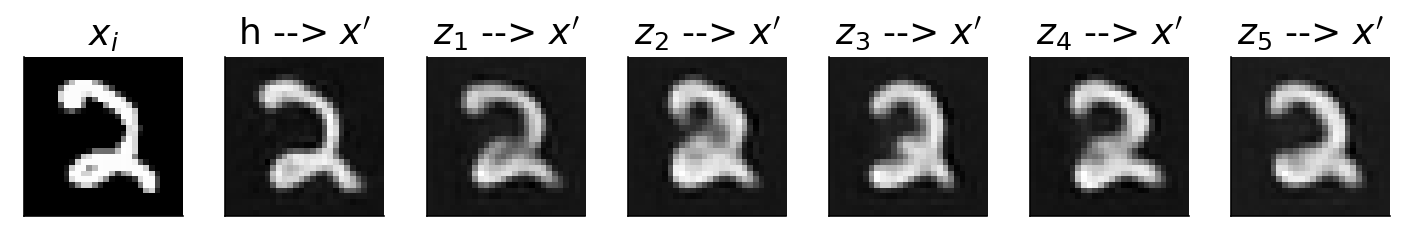

In [44]:
plt.figure(figsize=(10,3))
plt.subplot(1,7,1)
plot_torch_image(x_i[0])
plt.title('$x_i$')

orig_reconstruction = conv_ae.decode(h.view(1,K))[0].detach()
plt.subplot(1,7,2)
plot_torch_image(orig_reconstruction)
plt.title("h --> $x'$")

zs = rsample(phi.view(1,-1), 5)[0]
q_reconstructions = conv_ae.decode(zs).detach()
for i in range(5):
    plt.subplot(1,7,3+i)
    plot_torch_image(q_reconstructions[i])
    plt.title(f"$z_{i+1}$ --> $x'$")

You should see that the reconstructions from each sampled $\mathbf{z}$ vary slightly from each other, but that all are plausible reconstructions of the original $\mathbf{x}_i$. This proves that maximizing the ELBO by doing gradient descent on $\phi$ gives us the ability to reconstruct $\mathbf{x}$ a few different ways based on a __distribution__ of $\mathbf{z}$s.

(Your results may vary, depending on the dataset, $K$, number of optimization steps, etc).

## Build a VAE

You now have all the ingredients you need to build a VAE! The architecture in this example will be nearly identical to the `ConvAutoEncoder` from earlier, with a few key differences reflecting the fact that we're now thinking _distributionally_:

* The encoder is now a "recognition model" that outputs $\phi$ for each input rather than $\mathbf{h}$. All this means in the code is that the final linear layer which previously projected down to `K` dimensions will now project down to `K+1` dimensions (the size of $\phi$).
* The model will store `sig_x` as an extra parameter for the density network. In fact, we'll make `sig_x` learned from data as well.
* We'll train to maximize the ELBO

Video available at https://youtube.com/watch?v=QPPCjiN7UIk


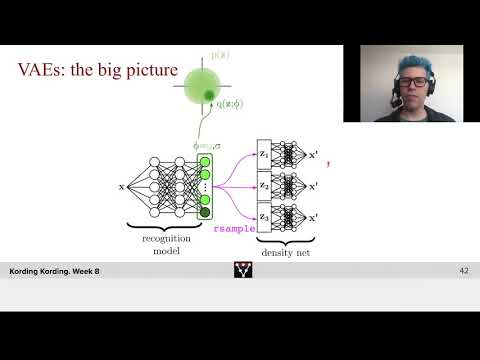

In [45]:
#@title Video: VAEs: the big picture

video = YouTubeVideo(id="QPPCjiN7UIk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

### Exercise 5 (Homework)
### Write a VAE with otherwise the same architecture as `ConvAutoEncoder`

This week's homework will be a little different, since it's partially part of the tutorials. Skip to the "wrapping up" section and return to this exercise as homework. It is a culmination of many ideas throughout this notebook and will likely take some time!

Note that we're actually not using `elbo()` from above, but rewriting it to be a member function of the `ConvVAE` class. This is simply to reduce the amount of reshaping you need to worry about, but they're functionally the same.

In [46]:
class ConvVAE(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=5):
        super(ConvVAE, self).__init__()
        
        # With padding=0, the number of pixels cut off from each image dimension
        # is filter_size // 2. Double it to get the amount of pixels lost in
        # width and height per Conv2D layer, or added back in per 
        # ConvTranspose2D layer.
        filter_reduction = 2 * (filter_size // 2)

        # After passing input through two Conv2d layers, the shape will be
        # 'shape_after_conv'. This is also the shape that will go into the first
        # deconvolution layer in the decoder
        self.shape_after_conv = (num_filters,
                                 my_dataset_size[1]-2*filter_reduction,
                                 my_dataset_size[2]-2*filter_reduction)
        flat_size_after_conv = self.shape_after_conv[0] \
            * self.shape_after_conv[1] \
            * self.shape_after_conv[2]
        ####################################################################
        # Fill in all missing code below (...),
        # then remove or comment the line below to test your class
        raise NotImplementedError("Please complete the ConvVAE class!")
        ####################################################################
        # Define the recognition model (encoder or q) part      
        ... # YOUR CODE HERE (BiasLayer, nn.Conv2d x2, nn.Flatten, nn.Linear)

        # Define the generative model (decoder or p) part
        ... # YOUR CODE HERE (nn.Linear, nn.Unflatten(-1, self.shape_after_conv), nn.ConvTranspose2d x2, BiasLayer)

        # Define a special extra parameter to learn scalar sig_x for all pixels.
        self.log_sig_x = nn.Parameter(torch.zeros(()))
    
    def infer(self, x):
        """Map (batch of) x to (batch of) phi which can then be passed to
        rsample to get z
        """
        ... # YOUR CODE HERE. Analogous to conv_ae.encode(). Output should be size [b,k+1]

    def generate(self, zs):
        """Map [b,n,k] sized samples of z to [b,n,p] sized images
        """
        b, n, k = zs.size()
        ... # YOUR CODE HERE. Analogous to conv_ae.decode(). Hint: requires zs.reshape() or zs.view() since nn.Linear expects (?, k) size inputs
    
    def forward(self, x):
        # VAE.forward() is not used for training, but we'll treat it like a
        # classic autoencoder by taking a single sample of z ~ q
        phi = self.infer(x)
        zs = rsample(phi, 1)
        return self.generate(zs).view(x.size())

    def elbo(self, x, n=1):
        """Run input end to end through the VAE and compute the ELBO using n
        samples of z
        """
        phi = self.infer(x)
        zs = rsample(phi, n)
        mu_xs = self.generate(zs)
        return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)

def train_vae(vae, dataset, epochs=10, n_samples=16):
    opt = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=1e-6)
    elbo_vals = []
    vae.to(DEVICE)
    vae.train()
    loader = DataLoader(dataset, batch_size=100, shuffle=True, pin_memory=True)
    for epoch in trange(epochs, desc='Epochs'):
        for im, _ in tqdm(loader, total=len(dataset)//100, desc='Batches', leave=False):
            im = im.to(DEVICE)
            opt.zero_grad()
            ####################################################################
            # Fill in all missing code below (...),
            # then remove or comment the line below to test your function
            raise NotImplementedError("Please complete the train_vae function!")
            ####################################################################
            loss = ... # YOUR CODE HERE (hint: use vae.elbo())
            loss.backward()
            opt.step()

            elbo_vals.append(-loss.item())
    vae.to('cpu')
    vae.eval()
    return elbo_vals

# Uncomment to train
# vae = ConvVAE(K=K)
# elbo_vals = train_vae(vae, my_dataset, n_samples=10)

# print(f'Learned sigma_x is {torch.exp(vae.log_sig_x)}')

# plt.figure()
# plt.plot(elbo_vals)
# plt.xlabel('Batch #')
# plt.ylabel('ELBO')
# plt.show()

## We can generate new images!

Remember that earlier we tried sampling $\mathbf{z} \sim p(\mathbf{z})$ and passing those through the `conv_ae.decode` function, and the results were ugly. The original autoencoder was never designed to work purely as a generative model.

Although we didn't go into details of the derivation (see Appendix A), VAEs and the ELBO objective come from applying the logic of generative models and maximum likelihood learning to autoencoders. So: do generated images now look like plausible "new images" or samples from the distribution of training images?

You can re-run this cell multiple times to see more examples.

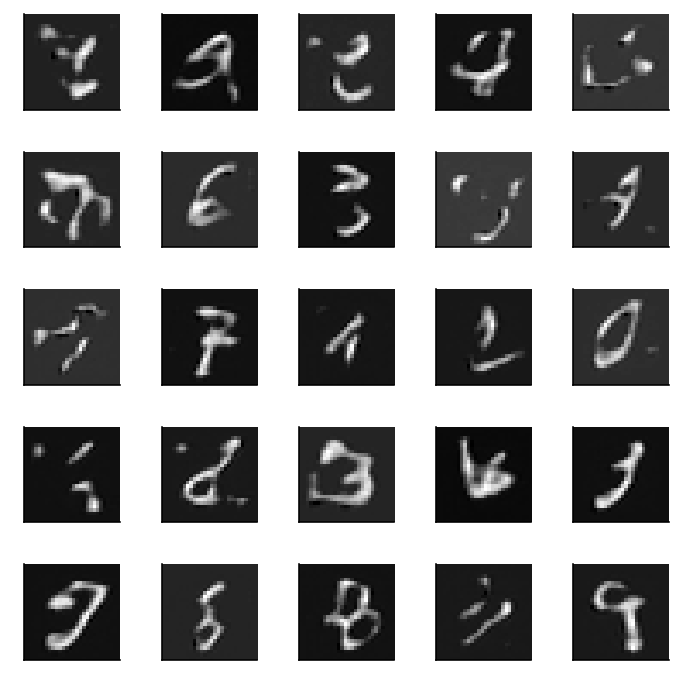

In [48]:
zs = torch.randn(1, 25, K)
vae_images = vae.generate(zs).reshape((25,) + my_dataset_size)

plt.figure(figsize=(5,5))
for i in range(25):
    plt.subplot(5,5,i+1)
    plot_torch_image(vae_images[i])
plt.show()

These won't be perfect, but hopefully they look a lot more like plausible "new" images!



Video available at https://youtube.com/watch?v=IDTq8muSySQ


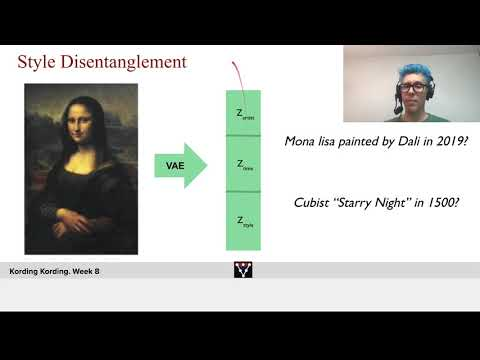

In [49]:
#@title Video: Wrapping up and interesting VAE examples

video = YouTubeVideo(id="IDTq8muSySQ", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Submit responses

In [50]:
import time
import numpy as np
from IPython.display import IFrame
#@markdown #Run Cell to Show Airtable Form
#@markdown Confirm your answers and then click "Submit". 
# If you're having issues, use this link and manually fill in your answers: https://airtable.com/shrh6lPiM4PlflEzj

def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefills = "&".join(["prefill_%s=%s"%(key, fields[key]) for key in fields])
  src = src + prefills
  src = "+".join(src.split(" "))
  return src

#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()

#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: my_email;
except NameError: my_email = ""

try: linear_ae_vs_pca;
except NameError: linear_ae_vs_pca = ""

try: interp_observations;
except NameError: interp_observations = ""

times = np.array([t1])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "tutorial": tutorial,
          "email": my_email,
          "linear_ae_vs_pca": linear_ae_vs_pca,
          "interp_observations": interp_observations,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrh6lPiM4PlflEzj?"

#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))


## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shr1TzujOOOY21kFQ">https://airtable.com/shr1TzujOOOY21kFQ</a>

In [51]:
# @title Feedback form
display(IFrame(src="https://airtable.com/embed/shr1TzujOOOY21kFQ", width = 800, height = 400))

---
# Appendices

## Appendix A: Formalizing the problem and deriving the ELBO

### Part A.1: maximum likelihood with neural networks

Let's state clearly the goal of learning a density network:

__Given:__

1. A latent space $\mathbf{z} \in \mathbb{R}^K$ with prior $p(\mathbf{z})$
2. Data points, $\lbrace{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N\rbrace}$ that live in $\mathbb{R}^P$ drawn (iid) from some unknown distribution $p_{true}(\mathbf{x})$ for instance, a set of training images sampled from the world, where $P$ is the number of pixels $\times$ color channels per image (e.g. $P=1\times 28 \times 28 = 784$ for MNIST, and $P=3\times 32 \times 32 = 3072$ for CIFAR).
3. A differentiable function (a neural network, say) with parameters $\mathbf{w}$ that maps from $\mathbb{R}^K$ to $\mathbb{R}^P$, $$\mathbf{x} = f(\mathbf{z};\mathbf{w}) \, .^\dagger$$ The decoder part of the AutoEncoder is an example of such an $f$.
4. A "noise model" on $\mathbf{x}$. Often this is simply chosen to be independent Gaussian pixel noise with $f(\mathbf{z};\mathbf{w})$ as the mean: $$p(\mathbf{x}|\mathbf{z};\mathbf{w}) = \mathcal{N}\left(f(\mathbf{z};\mathbf{w}), \sigma^2_x\mathbf{I}_P\right)$$
where $\mathbf{I}_P$ is the $P\times P$ identity matrix and is used to express the assumption that noise is independent across pixels.$^*$

Given all of this, a density network defines a distribution on $\mathbf{x}$:
$$p(\mathbf{x};\mathbf{w}) \equiv \int p(\mathbf{z}) p(\mathbf{x}|\mathbf{z};\mathbf{w}) \, {\rm d}\mathbf{z} \, .$$

Now, we can succinctly state that the __goal__ of learning a density network is to minimize the KL divergence from $p(\mathbf{x};\mathbf{w})$ to $p_{true}(\mathbf{x})$, or equivalently, to maximize the likelihood
$$\mathbf{w}^* = \arg\max_\mathbf{w} \sum_{i=1}^N \log p(\mathbf{x}_i;\mathbf{w}) \, .$$

But this is hard to do and requires approximations, which leads us to the ELBO.

---

### Part A.2: ELBO Derivation

The goal of training a density net is to maximize the (log) likelihood of points in the training set, or
$$\sum_{i=1}^N \log p(\mathbf{x}_i;\mathbf{w}) \, .$$

We already know all about minimizing sums of losses (e.g. minibatching and SGD), so let's focus on the loss for a single data point, $\log p(\mathbf{x}_i;\mathbf{w})$. With a bit of algebraic sleight of hand, we can pull out a $\mathbf{z}$ and start turning this into something more tractable$^\#$:
$$\log p(\mathbf{x}_i) = \log \left[ p(\mathbf{x}_i) \frac{p(\mathbf{z}|\mathbf{x}_i)}{p(\mathbf{z}|\mathbf{x}_i)} \right]\qquad\text{for all $\mathbf{z}$}$$
This step introduced a $\mathbf{z}$ out of nowhere. Since we are effectively multiplying and dividing by $1$, this holds no matter what $\mathbf{z}$ we plug in (we'll just ignore the possibility that $p(\mathbf{z}|\mathbf{x}_i)=0$). Next, we'll introduce a brand new auxiliary distribution, $q(\mathbf{z})$, and integrate it:
   $$\ldots = \int q(\mathbf{z}) \log \left[ p(\mathbf{x}_i) \frac{p(\mathbf{z}|\mathbf{x}_i)}{p(\mathbf{z}|\mathbf{x}_i)} \right] {\rm d} \mathbf{z}$$
This step initially seems odd: do we really get to pick _any_ $q(\mathbf{z})$ here? It works because we took an expression that was true _for all $\mathbf{z}$_, i.e. a constant function of $\mathbf{z}$, and integrated it with an arbitrary distribution on $\mathbf{z}$, which by definition has to integrate to its constant integrand. 

Next, we'll sneak $q$ inside the $\log$ using the same trick that got $p(\mathbf{z}|\mathbf{x}_i)$ in there, and we'll combine $p(\mathbf{z}|\mathbf{x}_i)p(\mathbf{x}_i)$ into a single $p(\mathbf{x}_i,\mathbf{z})$:
   $$\ldots = \int q(\mathbf{z}) \log \left[ \frac{p(\mathbf{x}_i,\mathbf{z})}{p(\mathbf{z}|\mathbf{x}_i)}\frac{q(\mathbf{z})}{q(\mathbf{z})} \right] {\rm d} \mathbf{z}$$
If you are beginning to think that this looks a bit like KL-divergence, then you would be right! Let's complete the transformation by pulling out $KL$:
$$\log p(\mathbf{x}_i) = KL\left(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}_i)\right) + \underbrace{\int q(\mathbf{z}) \log \left[ \frac{p(\mathbf{x}_i,\mathbf{z})}{q(\mathbf{z})} \right] {\rm d} \mathbf{z}}_\text{ELBO}$$

Re-arranging, notice that
$$\text{ELBO} = \log p(\mathbf{x}_i) - KL\left(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}_i)\right) \, .$$
We can get a lot of intuition out of this one expression. First, maximizing the ELBO has two effects, since there are two terms on the right hand side. The first effect is to make $KL(q(z)||p(z|x))$ smaller, which  means that by maximizing the ELBO, $q$ becomes a better approximation to the true posterior distribution over $z$. If $q$ were a _perfect fit_, that is if $q(z) = p(z|x)$, then maximizing the ELBO would be _equivalent_ to maximizing the thing we set out to maximize: the log likelihood of the data. Put another way: once $q$ is a good approximation to the posterior $p(z|x)$, then maximizing the ELBO makes $p(x|z)$ a better _generative_ model.

The ELBO gets its name because it is a **Lower BOund** on the **Evidence**. "Evidence" is just another term for the log likelihood, or $\log p(\mathbf{x}_i)$. We know that it is a lower bound beause $KL$ is always non-negative. This one formula is the work-horse of nearly all variational inference:
$$\color{red}{\log p(\mathbf{x}_i) \geq \underbrace{\int q(\mathbf{z}) \log \left[ \frac{p(\mathbf{x}_i,\mathbf{z})}{q(\mathbf{z})} \right] {\rm d} \mathbf{z}}_\text{ELBO}}$$

<!-- After all of that algebraic moving-around, you may be surprised to find that we've made some progress towards an expression that we can actually work with. It turns out that the ELBO makes many other nice and intuitive computational tricks available to us. Since the ELBO is a lower-bound on the log likelihood of the data, we _maximize_ it or, equivalently, do gradient _descent_ on the _negative_ ELBO. -->

Note that other texts often derive the ELBO in fewer steps using Jensen's inequality, but arguably some of the clarity and cleverness of the whole idea is lost when done that way. Here, we see behind the curtain a bit more: we see that $q(\mathbf{z})$ was introduced as a totally arbitrary distribution, but that we do "better" by making it agree more closely with $p(\mathbf{z}|\mathbf{x};\mathbf{w})$. We also see where the "Lower BOund" comes from: the ELBO is always a lower bound on $\log p(\mathbf{x}_i; \mathbf{w})$ precisely because $KL(q(\mathbf{z})||p(\mathbf{z}|\mathbf{x}_i;\mathbf{w}))$ is always positive. In fact, this tells us that the ELBO is **equal** to the log likelihood of the data (the bound is "tight") when $q(\mathbf{z})$ is equal to the correct posterior on $\mathbf{z}$, i.e. when $q(\mathbf{z}) = p(\mathbf{z}|\mathbf{x}_i)$. This means we can think about the problem of creating "tighter bounds" as a problem of making $q(\mathbf{z})$ closer to $p(\mathbf{z}|\mathbf{x}_i)$.

---

$^\dagger$ A notational convention is that $p(a|b)$ is used when $a$ and $b$ are both random variables and $a$ is "conditioned on" $b$, while $p(a;c)$ is used when $c$ is not a random variable, but a parameter controlling the shape of the distribution. This is sometimes written $p_c(a)$.

$^*$ In practice, we don't explicitly use $\mathbf{I}_P$. The assumption that pixel noise is independent instead appears as a sum of log-likelihoods per pixel.

$^\#$ these derivations drop the "$\mathbf{w}$" from all $p$s just to reduce clutter.

## Appendix B: Tricks

There are a few "tricks" behind VAEs in particular had a big impact on the field, and in this lesson we haven't dived into all of the interesting and non-obvious details.

1. The first "trick" was to recognize that the ELBO contains a "reconstruction" term and a "regularization" term, and that this naturally maps onto a kind of regularized auto-encoder. The original VAE paper is "Auto-Encoding Variational Bayes" because Variational Bayes and the ELBO had existed previously, but this was the first time it was built end-to-end with neural networks.

2. The second "trick" we introduced above without talking about it is the __reparameterization trick__. When we computed the ELBO, we simply called

        zs = rsample(phi, n)
        elbo = log_p_x(...) - kl_q_p(...)

    where each `...` depended on the sampled `zs`. Something sneaky is happening inside `rsample` which allows us to use Monte Carlo estimates of $\mathbb{E}_{q(\mathbf{z};\phi)}[\ldots]$ (as in the ELBO) but then take gradients of all of it with respect to $\phi$. Inside the `torch.distributions` package, you'll find both `sample` and `rsample` functions. The key difference is that you can take gradients through `rsample` but not through `sample`. Magic! (The "r" in "rsample" stands for "reparameterized sample".)

    For some extra history, before this simple trick came along, people generally thought of taking gradients with respect to $\phi$ in this kind of example as a hard problem. Keyword to search: score function estimators. Or see [here](http://blog.shakirm.com/2015/10/machine-learning-trick-of-the-day-4-reparameterisation-tricks/) and [here](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/) for some blog posts on the topic.

3. The third "trick" was when we stopped taking gradients of $\phi$ directly and instead used a __recognition model__ to map from $\mathbf{x}$ to $\phi$. This trick is also called "amortized inference" since the recognition model learns _on average_ to produce an estimate of $\phi$ for each $\mathbf{x}$.

## Appendix C: fraction of variance, eigenspectra, and selecting $K$

**tl;dr** one heuristic for choosing $K$ is to look at how much of the total variance in the data lies in the first $K$ principal components. But despite comparable variance-vs-K curves, you'll find that MNIST digits are legible with $K \approx 15$ while CIFAR images are unrecognizable until about $K \approx 80$. Reality is more complicated than percent variance explained!

Let's pause to think about our choice of the dimensionality of the bottleneck layer, $\mathbf{h}\in\mathbb{R}^K$. Dimensionality reduction by PCA works by projecting images onto the eigenvectors of the pixel covariance that have the largest eigenvalues. These eigenvalues, in turn, represent the amount of variance in the data along each of those vectors. So, we can visualize a rough, *linear* estimate of the intrinsic dimensionality of our datset by looking at its *eigenspectrum*.

Imagine we have a 3-dimensional dataset, and the eigenvalues of the covariance are, in descending order, $[3, 2, 1]$. Then the total variance would be $3+2+1=6$, and we would say that the first principal component accounts for $3/6=50\%$ of the total variance, while the first $K=2$ principal components account for a total of $(3+2)/6=83.3\%$ of the total variance.

MNIST is $28\times 28 = 784$-dimensional, and CIFAR is $32\times 32\times 3=3072$-dimensional. The following plot estimates the _fraction_ of that variance distributed across the first $K$ modes.

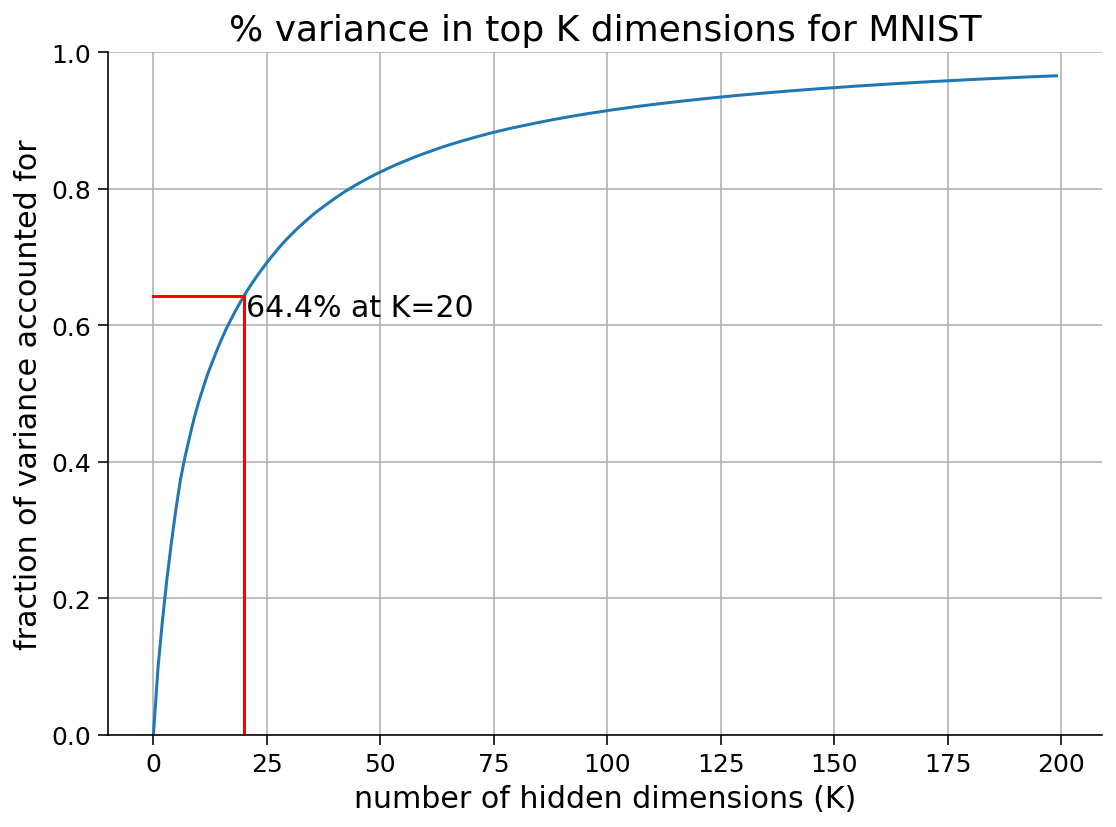

In [52]:
def plot_fraction_variance_eigenspectrum(cov, max_K=200, annotate_K=None, ax=None):
    ax = plt.gca() if ax is None else ax
    _, s, _ = torch.svd_lowrank(cov, q=max_K)
    rank = torch.arange(max_K+1)
    total_variance = cov.diag().sum()
    frac_variance = torch.cat([torch.zeros((1,)), torch.cumsum(s, dim=0) / total_variance])
    line = ax.plot(rank[:max_K], frac_variance[:max_K])
    if annotate_K is not None:
        y = frac_variance[K]
        ax.plot([K, K], [0, y], '-r')
        ax.plot([0, K], [y, y], '-r')
        ax.text(x=K+.5, y=y-.03, s=f'{100*y:.1f}% at K={K}')
    return line

plot_fraction_variance_eigenspectrum(cov, annotate_K=K)
plt.ylim([0., 1.])
plt.grid()
plt.xlabel('number of hidden dimensions (K)')
plt.ylabel('fraction of variance accounted for')
plt.title(f'% variance in top K dimensions for {my_dataset_name}')
plt.show()